In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../qbiome'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.style.use('ggplot')

from data_formatter import DataFormatter
from quantizer import Quantizer
from qnet_orchestrator import QnetOrchestrator
from forecaster import Forecaster

In [2]:
dirname = '../example_data/'
data = dirname + 'SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_TaxaRelativeAbundance.csv'
meta = dirname + 'SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_Characteristics.csv'

# Instantiate the data formatter, quantizer, qnet orchestrator, and forecaster

In [3]:
formatter = DataFormatter()
quantizer = Quantizer()
qnet_orchestrator = QnetOrchestrator(quantizer)
forecaster = Forecaster(qnet_orchestrator)

# Load, quantize, and convert the data to qnet input format

In [4]:
data = formatter.load_data(data, meta)
# populate the quantizer
quantized = quantizer.quantize_df(data)
features, label_matrix = quantizer.get_qnet_inputs(quantized)

There are 29 unique biomes and 1216 unique samples
There are 311 unique days
There are 99 unique weeks


In [5]:
# how many weeks of data do we have?
# how many biome_week feature names do we have?
data.week.max(), len(features)

(98, 621)

In [6]:
data.head()

,sample_id,subject_id,variable,week,value
7,MBSMPL0020-6-10,1,Actinobacteriota,27,0.366650
8,MBSMPL0020-6-10,1,Bacteroidota,27,0.507248
9,MBSMPL0020-6-10,1,Campilobacterota,27,0.002032
10,MBSMPL0020-6-10,1,Desulfobacterota,27,0.005058
11,MBSMPL0020-6-10,1,Firmicutes,27,0.057767


In [7]:
quantized.head()

,subject_id,Acidobacteriota_1,Acidobacteriota_9,Acidobacteriota_27,Acidobacteriota_31,Acidobacteriota_35,Actinobacteriota_1,Actinobacteriota_2,Actinobacteriota_3,Actinobacteriota_5,...,unclassified_Bacteria_31,unclassified_Bacteria_34,unclassified_Bacteria_36,unclassified_Bacteria_40,unclassified_Bacteria_48,unclassified_Bacteria_57,unclassified_Bacteria_62,unclassified_Bacteria_79,unclassified_Bacteria_80,unclassified_Bacteria_88
0,1,NaN,NaN,NaN,NaN,NaN,A,NaN,E,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12,NaN,NaN,NaN,NaN,NaN,D,NaN,NaN,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,A,...,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,NaN,NaN


# Construct a new subject

In [8]:
BIOMES = ['Actinobacteriota', 'Bacteroidota', 'Firmicutes', 'Proteobacteria', 'unclassified_Bacteria']

new_subject = pd.DataFrame({
    'week': [1] * len(BIOMES),
    'variable': BIOMES,
    'value': np.random.rand(len(BIOMES))
})

In [9]:
new_subject

,week,variable,value
0,1,Actinobacteriota,0.129319
1,1,Bacteroidota,0.122993
2,1,Firmicutes,0.916812
3,1,Proteobacteria,0.844172
4,1,unclassified_Bacteria,0.660276


In [10]:
new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id='101')

In [11]:
new_subject_quantized

,subject_id,Acidobacteriota_1,Acidobacteriota_9,Acidobacteriota_27,Acidobacteriota_31,Acidobacteriota_35,Actinobacteriota_1,Actinobacteriota_2,Actinobacteriota_3,Actinobacteriota_5,...,unclassified_Bacteria_31,unclassified_Bacteria_34,unclassified_Bacteria_36,unclassified_Bacteria_40,unclassified_Bacteria_48,unclassified_Bacteria_57,unclassified_Bacteria_62,unclassified_Bacteria_79,unclassified_Bacteria_80,unclassified_Bacteria_88
0,101,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# get inputs to qnet
_, label_matrix = quantizer.get_qnet_inputs(new_subject_quantized)

# Load a pre-trained qnet

In [13]:
qnet_orchestrator.load_qnet('../biome_net.joblib')

# Forecast the new subject

In [14]:
# takes 2 minutes to run
forecasted = forecaster.forecast_data(
    label_matrix, 
    start_week=1,
#     end_week=data.week.max()
)

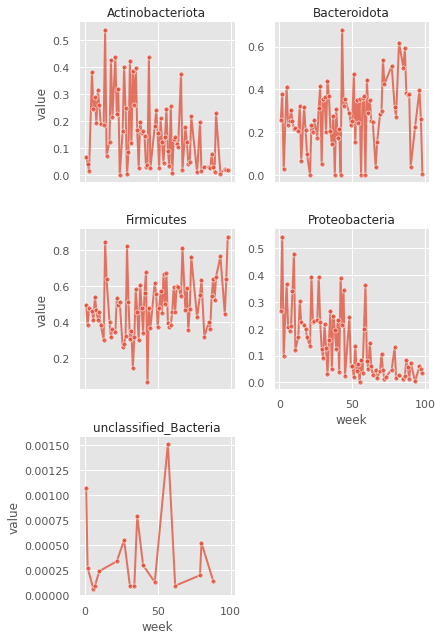

In [15]:
plottable = forecasted[forecasted.variable.isin(BIOMES)]

g = sns.FacetGrid(plottable, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()